In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

from datetime import datetime
import random

In [97]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [98]:
DATASET_PATH = 'train.csv'
PREDICT_PATH = 'test.csv'

In [99]:
# Импорт данных для тестовой выборки
df = pd.read_csv(DATASET_PATH, sep=',')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [100]:
# статистики по целевой переменной
target_mean = round(df['Price'].mean())
target_median = round(df['Price'].median())
target_mode = round(df['Price'].mode()[0])

target_bins = df['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

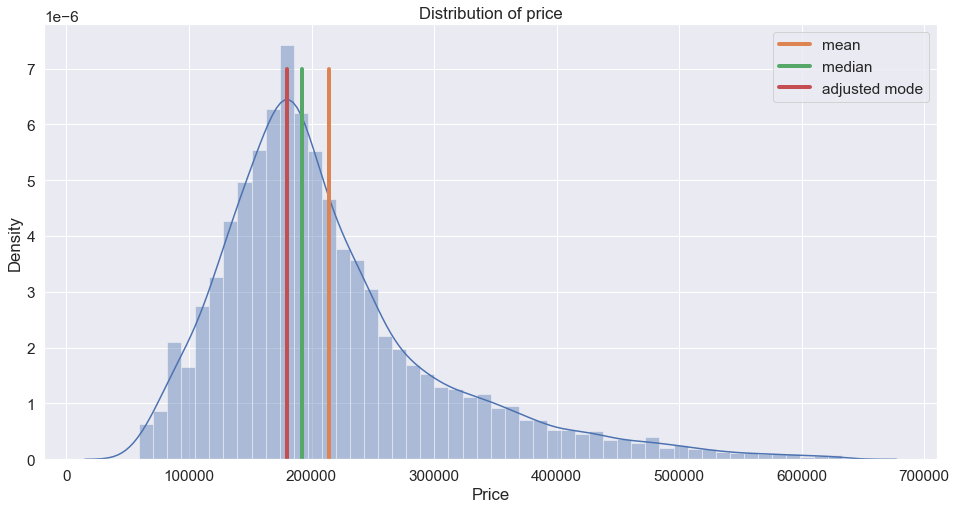

In [101]:
# график распределения целевой переменной
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50) 

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='adjusted mode', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

Распределение целевой переменной выглядит похоже на правду

In [102]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_by_square_median = None
        self.healthcare_by_district = None
        
    def fit(self, df):
        """Сохранение статистик"""
        self.medians = df.median()
        self.kitchen_by_square_median = self.medians.Square / self.medians.KitchenSquare
        self.healthcare_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Healthcare_1':'mean'})
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        # добавим метки для признаков с пропусками
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        df['Healthcare_1_nan'] = df['Healthcare_1'].isna() * 1
        
        # заменим пропуски в жилой площади квартиры на разницу между общей площадью и кухней
        df['LifeSquare'].fillna((df['Square'] - df['KitchenSquare']), inplace=True)
        
        # заменим пропуски в Healthcare_1 на среднее значение этого параметра по району
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = \
        df['DistrictId'].map(round(self.healthcare_by_district['Healthcare_1']))
        # на случай если все еще остались пропуски, заменим медианой
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)
        
        
        # 2. Выбросы (outliers)
        
        # Поменяем площади местами, если жилая площадь больше общей площади квартиры
        condition = df['LifeSquare'] > df['Square']
        df.loc[condition, 'LifeSquare'], df.loc[condition, 'Square'] = \
        df.loc[condition, 'Square'], df.loc[condition, 'LifeSquare']
        
        # Заменим максимальные значения площади медианами
        df.loc[df['Square'] > 215, 'Square'] = self.medians.Square
        df.loc[df['LifeSquare'] > 215, 'LifeSquare'] = self.medians.LifeSquare
        
        # Поменяем этажи местами, если этаж квартиры выше этажности дома
        condition = (df['Floor'] > df['HouseFloor'])
        df.loc[condition, 'Floor'], df.loc[condition, 'HouseFloor'] = \
        df.loc[condition, 'HouseFloor'], df.loc[condition, 'Floor']
        
        # Заменим в зависимости от общей площади площадь кухни, если она больше разницы между общей и жилой площадью квартиры 
        # и имеет при этом странное экстремальное значение
        df.loc[((df['KitchenSquare'] > (df['Square'] - df['LifeSquare'])) & (df['KitchenSquare'] > 20)), 'KitchenSquare'] \
        = df['Square'] / self.kitchen_by_square_median
        
        # Заменим экстремальные значения количества комнат и года постройки дома медианой
        df.loc[((df['Rooms'] == 0) | (df['Rooms'] >= 6)), 'Rooms'] = self.medians.Rooms
        df.loc[df['HouseYear'] > datetime.today().year, 'HouseYear'] = self.medians.HouseYear   
        
        # Заменим минимальные значения этажа квартиры на случайный этаж дома
        df.loc[df['Floor'] == 0, 'Floor'] = df['HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # Заменим минимальные значения площадей на значения соответствующие здравому смыслу
        df.loc[df['Square'] < 15, 'Square'] = 15
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 10
        df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        
        # 3. Обработка категориальных признаков
        df['Id'] = df['Id'].astype(str) # Id не принципиален, сделаем его категориальным
        df['DistrictId'] = df['DistrictId'].astype(str) # DistrictId не является количественным, сделаем его категориальным
        # заменим категориальные признаки, принимающие всего 2 значения, на бинарные
        df.replace({'Ecology_2':{'A':0, 'B':1}}, inplace=True)
        df.replace({'Ecology_3':{'A':0, 'B':1}}, inplace=True)
        df.replace({'Shops_2':{'A':0, 'B':1}}, inplace=True)
        
        return df

In [103]:
class NewFeatures:
    """Новые фичи"""
    
    def __init__(self):
        
        self.sq_price_by_district = None
        self.med_sq_price_by_district = None
        self.rooms_price_by_district = None
        self.room_price_by_district = None
        self.med_room_price_by_district = None
        self.year_by_district = None
        self.med_year_by_district = None
        
    def fit(self, df, y=None):
        """Сохранение статистик"""
        
        if y is not None:
            df['Price'] = y.values       
  
            self.sq_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Square':'sum', 'Price':'sum'})
            self.sq_price_by_district['SquarePriceByDistrict'] = \
            self.sq_price_by_district['Price'] / self.sq_price_by_district['Square']
            self.med_sq_price_by_district = self.sq_price_by_district['SquarePriceByDistrict'].median()
            
            self.rooms_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
            .rename(columns={'Price':'RoomsPriceByDistrict'})
            
            self.room_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Rooms':'sum','Price':'sum'})
            self.med_room_price_by_district = \
            (self.room_price_by_district['Price'] / self.room_price_by_district['Rooms']).median()
        
            df.drop('Price', axis=1, inplace=True)
        
        self.year_by_district = df.groupby(['DistrictId'], as_index=False).agg({'HouseYear':'median'})\
        .rename(columns={'HouseYear': 'YearByDistrict'})
        self.med_year_by_district = self.year_by_district['YearByDistrict'].median()
        
    def transform(self, df):
        """Трансформация данных"""

        if self.sq_price_by_district is not None:
        # Добавим среднюю цену за кв.метр в районе, заменим пропуски медианой
            df = df.merge(self.sq_price_by_district.drop(['Square', 'Price'], axis=1), on='DistrictId', how='left')
            df.loc[df['SquarePriceByDistrict'].isna(), 'SquarePriceByDistrict'] = self.med_sq_price_by_district
            
        if self.rooms_price_by_district is not None:
        # Добавим среднюю цену за квартиру из указанного кол-ва комнат в районе, заменим пропуски медианой
            df = df.merge(self.rooms_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df.loc[df['RoomsPriceByDistrict'].isna(), 'RoomsPriceByDistrict'] = self.med_room_price_by_district * df['Rooms']
        
        # Добавим средний год постройки дома в районе, заменим пропуски медианой
        df = df.merge(self.year_by_district, on='DistrictId', how='left')
        df.loc[df['YearByDistrict'].isna(), 'YearByDistrict'] = self.med_year_by_district
        
        return df

In [104]:
# Импорт данных для результирующей выборки
test_df = pd.read_csv(PREDICT_PATH, sep=',')
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [105]:
# Отделение целевой переменной от тестовой выборки
X = df.drop('Price', axis=1)
y = df['Price']

# Трансформация данных
pipe = DataPipeline()
pipe.fit(X)
X = pipe.transform(X)
test_df = pipe.transform(test_df)

newfeatures = NewFeatures()
newfeatures.fit(X, y)
X = newfeatures.transform(X)
test_df = newfeatures.transform(test_df)

# Разбиение данных на наборы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Проверка на полный комплект признаков и отсутствие пропусков
print(X_train.shape, X_valid.shape, test_df.shape)
print(X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum())

(8000, 24) (2000, 24) (5000, 24)
0 0 0


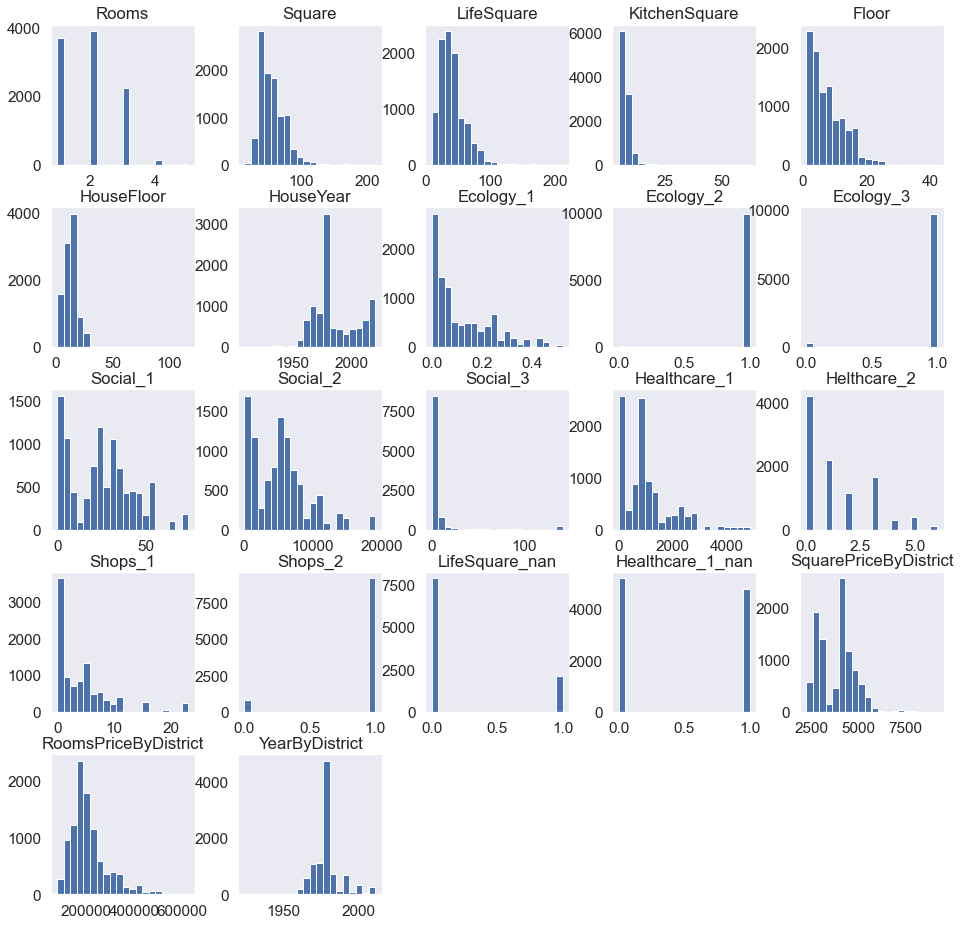

In [106]:
# убедимся, что распределение признаков после обработки выглядит адекватно
X.hist(figsize=(16, 16), bins=20, grid=False);

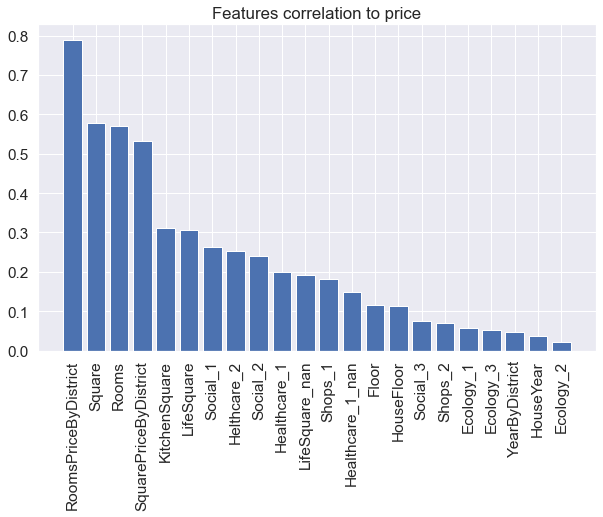

In [107]:
# посмотрим, с какими признаками и насколько корреллирует целевая переменная
correlation = X.corrwith(y).abs().sort_values(ascending=False)
plt.figure(figsize = (10, 6))
plt.bar(correlation.index, correlation.values)
plt.title('Features correlation to price')
plt.xticks(rotation='vertical')
plt.show()

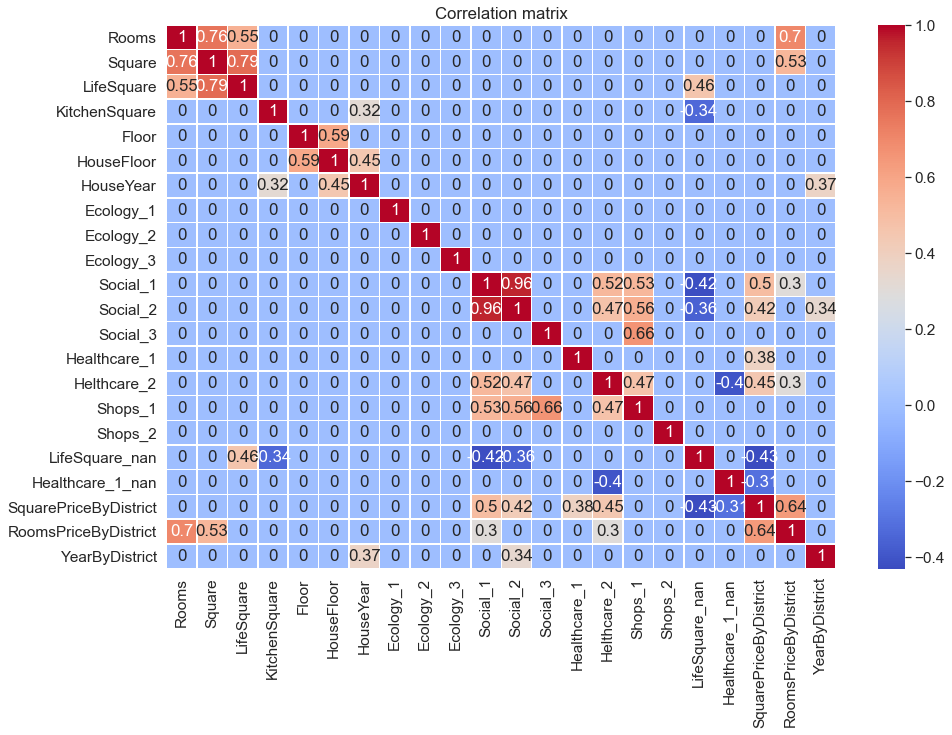

In [108]:
# убедимся, что новые признаки не сильно корреллируют между собой и с уже имеющимися признаками
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [109]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и график preds vs true"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)) + "\n" +
          "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3))
         )
    
    plt.figure(figsize=(18,8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values on Train')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values on Test')
    
    plt.show()

Train R2:	0.859
Test R2:	0.747


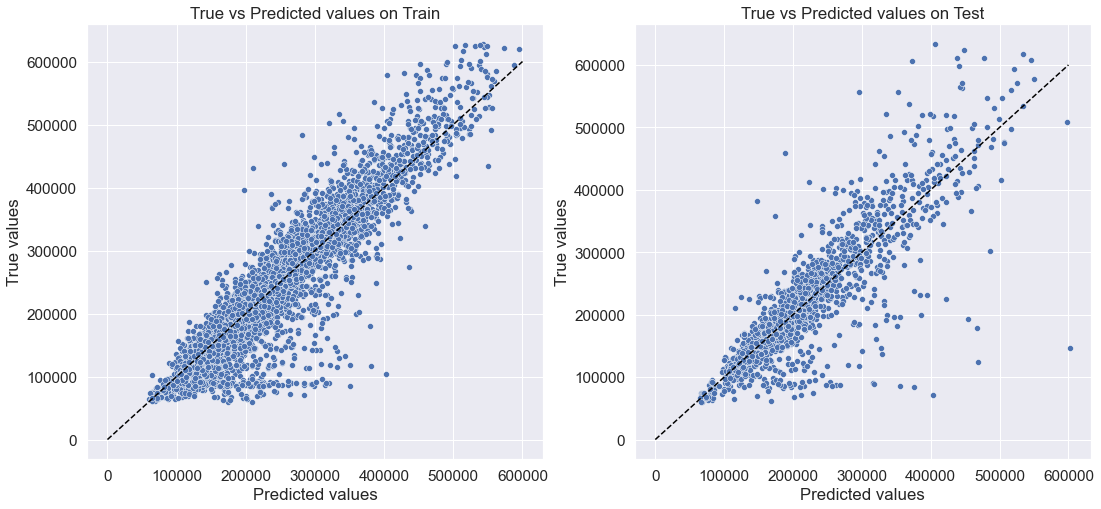

In [110]:
model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=200)
model.fit(X_train, y_train)

y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [111]:
# посмотрим, какие признаки влияют на цену
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
22,RoomsPriceByDistrict,0.690665
3,Square,0.122997
21,SquarePriceByDistrict,0.055445
5,KitchenSquare,0.020594
8,HouseYear,0.016980
7,HouseFloor,0.012135
4,LifeSquare,0.011633
12,Social_1,0.010573
14,Social_3,0.009195
13,Social_2,0.009071


In [112]:
# обучим модель на полном тестовом наборе и рассчитаем целевую переменную для результирующей выборки
model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=200)
model.fit(X, y)

predictions = model.predict(test_df)
predictions

array([156499.73431577, 233388.26029728, 138180.34733781, ...,
       314881.44551861, 184047.03342618, 179974.20388897])

In [113]:
final_df = pd.DataFrame(zip(test_df['Id'], predictions), columns=['Id', 'Price'])
final_df.head()

,Id,Price
0,725,156499.734316
1,15856,233388.260297
2,5480,138180.347338
3,15664,300222.485585
4,14275,135941.806927


In [114]:
final_df.to_csv('ISeliugina_predictions.csv', index=False)